In [75]:
import numpy as np
import pandas as pd
import random
from scipy.linalg import norm
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, argparse
import multiprocessing as mp
import missingno

# machine learning
import sklearn.cluster
import sklearn
import sklearn.preprocessing
import sklearn.decomposition
from sklearn.model_selection import train_test_split

###1. Load Data and Splot Data
from keras.models import Sequential 
from keras.layers.core import Dense, Activation
from keras.utils import np_utils

#--- custom libs
wdir = "/work/kaggle/molecules/src"
if wdir:
    sys.path.insert(0, wdir)
import sfuncs as sff
import funcs as ff

plt.style.use('dark_background')

Using TensorFlow backend.


# > Descriptores de la distribucion espacial de los átomos
# entre sí (en terminos de distancia y distribuciones angulares)

In [2]:
df = pd.read_csv("../data/postproc/descriptors_sample.csv", sep=';')

In [3]:
df.columns

Index(['Unnamed: 0', 'molecule_name', 'atom_index', 'desc_g2ang_00',
       'desc_g2ang_01', 'desc_g2ang_02', 'desc_g2ang_03', 'desc_g2ang_04',
       'desc_g2ang_05', 'desc_g2rad_00', 'desc_g2rad_01', 'desc_g2rad_02',
       'desc_g2rad_03'],
      dtype='object')

In [4]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [5]:
df.head()

molecule_name  atom_index  desc_g2ang_00  desc_g2ang_01  desc_g2ang_02  \
0  dsgdb9nsd_073799           0       0.547233       0.029197       6.160965   
1  dsgdb9nsd_073799           1       0.094606       0.000555       7.521452   
2  dsgdb9nsd_073799           2       0.091354       0.000446       7.452496   
3  dsgdb9nsd_073799           3       0.548031       0.029286       6.247297   
4  dsgdb9nsd_073799           4       0.086203       0.000814       9.040215   

   desc_g2ang_03  desc_g2ang_04  desc_g2ang_05  desc_g2rad_00  desc_g2rad_01  \
0       2.874391      48.005857      21.877733       2.930076       3.070760   
1       1.480662      81.585363      36.027836       3.222217       6.688551   
2       1.438356      90.420206      40.950256       3.064127       9.215784   
3       2.903426      57.968340      25.731346       2.928051       3.225681   
4       2.268404      85.743853      45.369535       4.261345       6.875405   

   desc_g2rad_02  desc_g2rad_03  
0       4.405743       3.178821  
1       5.392217       0.347580  
2       4.079353       0.014046  
3       6.440143       1.774062  
4       3.627894       0.844526

# > Mulliken charges

In [19]:
df_mulliken = pd.read_csv("../data/mulliken_charges.csv", sep=',')

In [20]:
df_mulliken.head(10)

molecule_name  atom_index  mulliken_charge
0  dsgdb9nsd_000001           0        -0.535689
1  dsgdb9nsd_000001           1         0.133921
2  dsgdb9nsd_000001           2         0.133922
3  dsgdb9nsd_000001           3         0.133923
4  dsgdb9nsd_000001           4         0.133923
5  dsgdb9nsd_000002           0        -0.707143
6  dsgdb9nsd_000002           1         0.235712
7  dsgdb9nsd_000002           2         0.235712
8  dsgdb9nsd_000002           3         0.235720
9  dsgdb9nsd_000003           0        -0.589706

In [8]:
#%pdb

In [21]:
df_mulliken.columns.values

array(['molecule_name', 'atom_index', 'mulliken_charge'], dtype=object)

In [22]:
"molecule_name" in df.columns, "molecule_name" in df_mulliken.columns

(True, True)

In [34]:
df_merge = pd.merge(df, df_mulliken, how="left", on=["molecule_name", "atom_index"])

In [57]:
(~df_merge["mulliken_charge"].isna()).nonzero()[0].size / df_merge.shape[0]

/home/jim/anaconda/envs/kgg_mole/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  """Entry point for launching an IPython kernel.


1.0

In [55]:
missingno.bar(df_merge, figsize=(15,4))

In [56]:
df_merge.dropna(axis=0, how='any', subset=["mulliken_charge",], inplace=True)

In [63]:
df_merge.reset_index(drop=True, inplace=True)
df_merge.head(15)

molecule_name  atom_index  desc_g2ang_00  desc_g2ang_01  desc_g2ang_02  \
0   dsgdb9nsd_017630           0       0.547949       0.028633       7.194091   
1   dsgdb9nsd_017630           1       0.241922       0.003339       8.757507   
2   dsgdb9nsd_017630           2       0.333929       0.002805       4.685400   
3   dsgdb9nsd_017630           3       0.239345       0.003175       8.531849   
4   dsgdb9nsd_017630           4       0.332514       0.002708       4.691544   
5   dsgdb9nsd_017630           5       0.249045       0.003569       8.438177   
6   dsgdb9nsd_017630           6       0.412580       0.012223       6.882280   
7   dsgdb9nsd_017630           7       0.294752       0.004150       6.226456   
8   dsgdb9nsd_017630           8       0.204288       0.002697       5.070745   
9   dsgdb9nsd_017630           9       0.205319       0.002747       5.242483   
10  dsgdb9nsd_017630          10       0.201256       0.002786       5.304461   
11  dsgdb9nsd_017630          11       0.172722       0.000579       5.069261   
12  dsgdb9nsd_017630          12       0.302460       0.000566       3.499560   
13  dsgdb9nsd_017630          13       0.171782       0.000557       5.289271   
14  dsgdb9nsd_017630          14       0.301996       0.000548       3.414977   

    desc_g2ang_03  desc_g2ang_04  desc_g2ang_05  desc_g2rad_00  desc_g2rad_01  \
0        3.249508      49.571979      24.492797       3.001572       4.125113   
1        2.760895      68.680336      36.980874       4.010415       5.631628   
2        0.947778      56.289402      15.987486       1.638641       4.861539   
3        2.655352      76.493828      41.014486       3.849984       8.122131   
4        0.979281      58.184220      17.005142       1.637393       5.258157   
5        2.544136      66.661271      34.315206       3.819794       5.990429   
6        2.636163      48.479012      21.831708       3.385609       2.682549   
7        1.530729      49.111491      15.841633       2.644295       3.578587   
8        0.522986      40.373579       6.769982       1.800568       2.781075   
9        0.571870      46.704413       9.955377       1.808596       3.632109   
10       0.608282      47.126864      10.326532       1.836168       3.903655   
11       0.625274      61.867333      15.576761       1.097501       7.137028   
12       0.360387      50.180153      10.153141       0.748223       4.626119   
13       0.707514      71.776857      21.327982       1.096418       8.547974   
14       0.342176      49.841973       9.394589       0.737381       4.591038   

    desc_g2rad_02  desc_g2rad_03  mulliken_charge  
0        2.274815       2.335652        -0.407773  
1        3.144253       0.431052         0.117649  
2        5.175452       0.771365        -0.426036  
3        2.223539       0.016529         0.068147  
4        5.052657       0.650426        -0.429458  
5        2.434290       0.844743         0.012589  
6        4.089985       1.728560        -0.235162  
7        2.489373       2.026450        -0.325393  
8        2.767152       1.684364         0.121494  
9        2.755012       2.162122         0.135998  
10       2.437441       2.630831         0.103203  
11       2.674112       1.325034         0.081392  
12       5.254099       1.291286         0.278311  
13       3.318917       0.053009         0.069190  
14       4.676210       1.494685         0.286031

In [64]:
df_merge.shape

(153717, 13)

In [81]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_merge.drop(["molecule_name", "atom_index", "mulliken_charge"], axis=1),
    df_merge[["mulliken_charge",]],
    train_size=0.75
    )

In [82]:
X_train.shape, Y_train.shape

((115287, 10), (115287, 1))

In [215]:
X_train.describe()

desc_g2ang_00  desc_g2ang_01  desc_g2ang_02  desc_g2ang_03  \
count  115287.000000   1.152870e+05  115287.000000   1.152870e+05   
mean        0.231328   4.009209e-03       5.204586   1.094109e+00   
std         0.109981   6.619703e-03       1.639662   9.380920e-01   
min         0.038981   1.593799e-15       1.313535   6.439932e-10   
25%         0.180845   7.033452e-04       4.203389   4.267927e-01   
50%         0.200817   1.686425e-03       4.917634   5.702650e-01   
75%         0.258577   2.881497e-03       6.374702   1.899115e+00   
max         0.755744   6.214248e-02      11.145677   3.872700e+00   

       desc_g2ang_04  desc_g2ang_05  desc_g2rad_00  desc_g2rad_01  \
count  115287.000000  115287.000000  115287.000000  115287.000000   
mean       48.572024      15.490221       2.078107       3.991222   
std        15.264571      10.353949       0.994888       1.570686   
min         5.663397       0.000008       0.649324       0.000443   
25%        38.219622       7.586231       1.295837       2.876557   
50%        47.830567      12.110789       1.827976       3.919415   
75%        58.356344      22.410730       3.005686       5.011355   
max       138.505624      73.171623       4.550532      12.093716   

       desc_g2rad_02  desc_g2rad_03  
count  115287.000000   1.152870e+05  
mean        3.569867   1.398887e+00  
std         1.268036   9.078482e-01  
min         0.000001   2.550361e-14  
25%         2.645896   6.508293e-01  
50%         3.526244   1.350541e+00  
75%         4.425675   2.025882e+00  
max         9.063819   5.598738e+00

In [247]:
np.max(X_train_cent.abs())

desc_g2ang_00     0.524416
desc_g2ang_01     0.058133
desc_g2ang_02     5.941091
desc_g2ang_03     2.778591
desc_g2ang_04    89.933600
desc_g2ang_05    57.681402
desc_g2rad_00     2.472426
desc_g2rad_01     8.102494
desc_g2rad_02     5.493953
desc_g2rad_03     4.199851
dtype: float64

In [315]:
scl_mean = X_train.mean(axis=0)
X_train_cent = X_train - scl_mean
scl_norm = np.max(X_train_cent.abs().max())
X_train_norm = pd.DataFrame(X_train_cent / scl_norm, dtype=np.float32)

In [317]:
X_train_norm.describe()

desc_g2ang_00  desc_g2ang_01  desc_g2ang_02  desc_g2ang_03  \
count   1.152870e+05   1.152870e+05   1.152870e+05   1.152870e+05   
mean   -9.047692e-13   2.423489e-14   4.523846e-12  -2.972813e-12   
std     1.222909e-03   7.360656e-05   1.823192e-02   1.043094e-02   
min    -2.138761e-03  -4.457966e-05  -4.326582e-02  -1.216575e-02   
25%    -5.613338e-04  -3.675894e-05  -1.113262e-02  -7.420103e-03   
50%    -3.392542e-04  -2.582777e-05  -3.190714e-03  -5.824790e-03   
75%     3.029917e-04  -1.253939e-05   1.301089e-02   8.951112e-03   
max     5.831145e-03   6.464021e-04   6.606086e-02   3.089602e-02   

       desc_g2ang_04  desc_g2ang_05  desc_g2rad_00  desc_g2rad_01  \
count   1.152870e+05   1.152870e+05   1.152870e+05  115287.000000   
mean   -7.651763e-11   5.170110e-11   1.034022e-12       0.000000   
std     1.697316e-01   1.151288e-01   1.106248e-02       0.017465   
min    -4.771145e-01  -1.722406e-01  -1.588708e-02      -0.044375   
25%    -1.151116e-01  -8.788695e-02  -8.698303e-03      -0.012394   
50%    -8.244492e-03  -3.757697e-02  -2.781275e-03      -0.000798   
75%     1.087949e-01   7.695132e-02   1.031405e-02       0.011343   
max     1.000000e+00   6.413777e-01   2.749168e-02       0.090094   

       desc_g2rad_02  desc_g2rad_03  
count   1.152870e+05   1.152870e+05  
mean    1.292527e-12   1.809538e-12  
std     1.409970e-02   1.009465e-02  
min    -3.969445e-02  -1.555467e-02  
25%    -1.027392e-02  -8.317893e-03  
50%    -4.850488e-04  -5.375803e-04  
75%     9.516003e-03   6.971747e-03  
max     6.108899e-02   4.669946e-02

### NN parameters

In [142]:
input_size = X_train.shape[1]
batch_size = 200
hidden1 = 5
hidden2 = 3
epochs = 10

### Building the FCN Model
#### > test 1: n-hidden=(64, 4), losss='mean_absolute_error', optimizer = 'adam'

In [295]:
###4.Build the model
model = Sequential()     
model.add(Dense(8, input_dim=input_size, activation='relu'))
# output = relu (dot (W, input) + bias)
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

# Compilation
model.compile(
    loss = 'mean_absolute_error', 
    optimizer = 'adam', #'sgd'
    )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_66 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 129       
Total params: 1,369
Trainable params: 1,369
Non-trainable params: 0
_________________________________________________________________


In [287]:
np.std(Y_train)**2

mulliken_charge    0.050627
dtype: float64

In [288]:
X_train_norm.shape[0]

115287

In [296]:
# Fitting on Data
hist = model.fit(X_train_norm.values, Y_train.values,
    batch_size = int(0.01 * X_train.shape[0]),
    epochs = 512,
    validation_split = 0.2,
    verbose = 2)

Train on 92229 samples, validate on 23058 samples
Epoch 1/512
 - 3s - loss: 0.1534 - val_loss: 0.1430
Epoch 2/512
 - 1s - loss: 0.1396 - val_loss: 0.1368
Epoch 3/512
 - 1s - loss: 0.1331 - val_loss: 0.1328
Epoch 4/512
 - 2s - loss: 0.1284 - val_loss: 0.1270
Epoch 5/512
 - 1s - loss: 0.1248 - val_loss: 0.1236
Epoch 6/512
 - 1s - loss: 0.1217 - val_loss: 0.1203
Epoch 7/512
 - 1s - loss: 0.1181 - val_loss: 0.1169
Epoch 8/512
 - 1s - loss: 0.1146 - val_loss: 0.1125
Epoch 9/512
 - 1s - loss: 0.1109 - val_loss: 0.1090
Epoch 10/512
 - 1s - loss: 0.1076 - val_loss: 0.1061
Epoch 11/512
 - 1s - loss: 0.1045 - val_loss: 0.1050
Epoch 12/512
 - 1s - loss: 0.1025 - val_loss: 0.1014
Epoch 13/512
 - 1s - loss: 0.1005 - val_loss: 0.0992
Epoch 14/512
 - 1s - loss: 0.0986 - val_loss: 0.0973
Epoch 15/512
 - 1s - loss: 0.0969 - val_loss: 0.0963
Epoch 16/512
 - 1s - loss: 0.0953 - val_loss: 0.0940
Epoch 17/512
 - 1s - loss: 0.0935 - val_loss: 0.0933
Epoch 18/512
 - 1s - loss: 0.0921 - val_loss: 0.0912
Epoch

Epoch 154/512
 - 1s - loss: 0.0413 - val_loss: 0.0427
Epoch 155/512
 - 1s - loss: 0.0411 - val_loss: 0.0422
Epoch 156/512
 - 1s - loss: 0.0411 - val_loss: 0.0420
Epoch 157/512
 - 1s - loss: 0.0410 - val_loss: 0.0431
Epoch 158/512
 - 2s - loss: 0.0410 - val_loss: 0.0429
Epoch 159/512
 - 4s - loss: 0.0413 - val_loss: 0.0434
Epoch 160/512
 - 5s - loss: 0.0411 - val_loss: 0.0426
Epoch 161/512
 - 4s - loss: 0.0408 - val_loss: 0.0426
Epoch 162/512
 - 2s - loss: 0.0408 - val_loss: 0.0439
Epoch 163/512
 - 1s - loss: 0.0411 - val_loss: 0.0415
Epoch 164/512
 - 1s - loss: 0.0408 - val_loss: 0.0416
Epoch 165/512
 - 1s - loss: 0.0410 - val_loss: 0.0417
Epoch 166/512
 - 1s - loss: 0.0407 - val_loss: 0.0425
Epoch 167/512
 - 1s - loss: 0.0409 - val_loss: 0.0429
Epoch 168/512
 - 1s - loss: 0.0406 - val_loss: 0.0429
Epoch 169/512
 - 1s - loss: 0.0406 - val_loss: 0.0432
Epoch 170/512
 - 1s - loss: 0.0408 - val_loss: 0.0448
Epoch 171/512
 - 1s - loss: 0.0407 - val_loss: 0.0422
Epoch 172/512
 - 1s - loss: 

Epoch 306/512
 - 1s - loss: 0.0376 - val_loss: 0.0412
Epoch 307/512
 - 1s - loss: 0.0376 - val_loss: 0.0381
Epoch 308/512
 - 1s - loss: 0.0371 - val_loss: 0.0382
Epoch 309/512
 - 4s - loss: 0.0371 - val_loss: 0.0388
Epoch 310/512
 - 4s - loss: 0.0373 - val_loss: 0.0378
Epoch 311/512
 - 4s - loss: 0.0371 - val_loss: 0.0378
Epoch 312/512
 - 1s - loss: 0.0371 - val_loss: 0.0376
Epoch 313/512
 - 1s - loss: 0.0369 - val_loss: 0.0466
Epoch 314/512
 - 1s - loss: 0.0378 - val_loss: 0.0378
Epoch 315/512
 - 3s - loss: 0.0370 - val_loss: 0.0390
Epoch 316/512
 - 3s - loss: 0.0371 - val_loss: 0.0386
Epoch 317/512
 - 3s - loss: 0.0369 - val_loss: 0.0405
Epoch 318/512
 - 1s - loss: 0.0377 - val_loss: 0.0375
Epoch 319/512
 - 1s - loss: 0.0369 - val_loss: 0.0383
Epoch 320/512
 - 1s - loss: 0.0369 - val_loss: 0.0373
Epoch 321/512
 - 1s - loss: 0.0368 - val_loss: 0.0379
Epoch 322/512
 - 1s - loss: 0.0370 - val_loss: 0.0377
Epoch 323/512
 - 1s - loss: 0.0369 - val_loss: 0.0379
Epoch 324/512
 - 1s - loss: 

Epoch 458/512
 - 1s - loss: 0.0348 - val_loss: 0.0375
Epoch 459/512
 - 1s - loss: 0.0355 - val_loss: 0.0371
Epoch 460/512
 - 1s - loss: 0.0351 - val_loss: 0.0395
Epoch 461/512
 - 4s - loss: 0.0355 - val_loss: 0.0388
Epoch 462/512
 - 4s - loss: 0.0352 - val_loss: 0.0361
Epoch 463/512
 - 1s - loss: 0.0352 - val_loss: 0.0355
Epoch 464/512
 - 1s - loss: 0.0348 - val_loss: 0.0356
Epoch 465/512
 - 1s - loss: 0.0347 - val_loss: 0.0352
Epoch 466/512
 - 1s - loss: 0.0348 - val_loss: 0.0357
Epoch 467/512
 - 1s - loss: 0.0348 - val_loss: 0.0355
Epoch 468/512
 - 1s - loss: 0.0347 - val_loss: 0.0356
Epoch 469/512
 - 1s - loss: 0.0348 - val_loss: 0.0356
Epoch 470/512
 - 1s - loss: 0.0350 - val_loss: 0.0372
Epoch 471/512
 - 2s - loss: 0.0352 - val_loss: 0.0361
Epoch 472/512
 - 4s - loss: 0.0348 - val_loss: 0.0359
Epoch 473/512
 - 3s - loss: 0.0348 - val_loss: 0.0357
Epoch 474/512
 - 4s - loss: 0.0348 - val_loss: 0.0358
Epoch 475/512
 - 3s - loss: 0.0349 - val_loss: 0.0362
Epoch 476/512
 - 2s - loss: 

In [268]:
X_test.values.shape

(38430, 10)

#### > test 5: n-hidden=(8, 128), losss='mean_absolute_error', optimizer = 'adam'

38430/38430 [==============================] - 5s 138us/step

Test accuracy: 0.03432132858756834
 --> plotting...


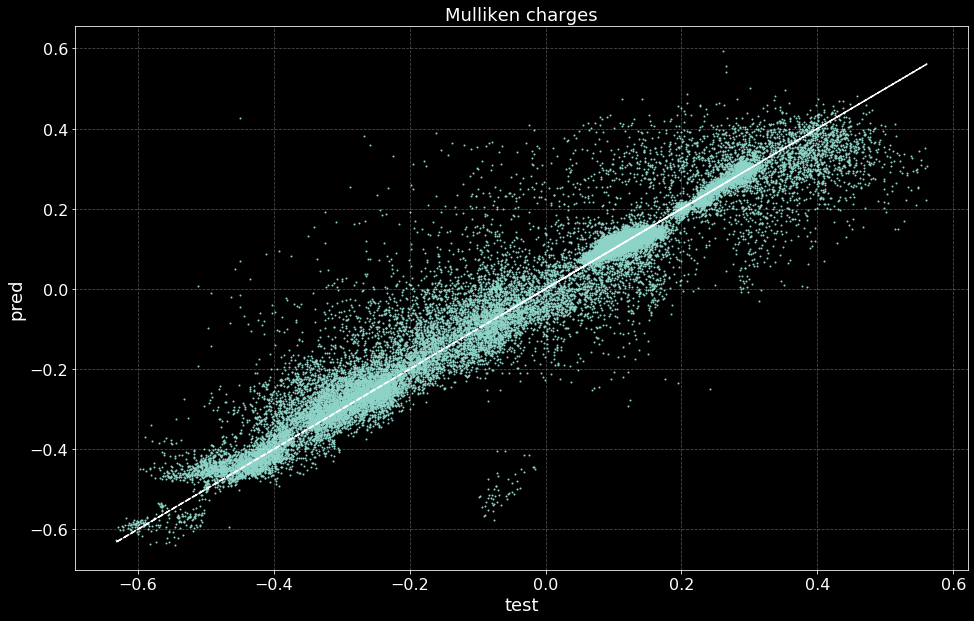

In [297]:
score = model.evaluate((X_test - scl_mean)/scl_norm, Y_test, verbose=1)
print('\nTest accuracy:', score)

y_pred = model.predict((X_test - scl_mean).values/scl_norm)
y_pred

print(" --> plotting...")
plt.figure(figsize=(16,10))
plt.scatter(Y_test, y_pred, s=1)
plt.plot(Y_test, Y_test, '--w')
plt.grid(ls='--', alpha=0.3)
plt.title("Mulliken charges", fontsize=18)
plt.xlabel("test", fontsize=18); plt.ylabel("pred", fontsize=18);
plt.tick_params(labelsize=16)

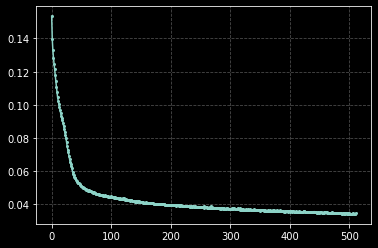

In [298]:
plt.plot(hist.history["loss"], '-o', ms=2)
#plt.yscale("log")
plt.grid(ls='--', alpha=0.3)

#### > test 4: n-hidden=(64, 4), losss='mean_absolute_error', optimizer = 'adam', (nro de capas)=n1,n2,n3=128,8,1

In [290]:
score = model.evaluate((X_test - scl_mean)/scl_norm, Y_test, verbose=1)
print('\nTest accuracy:', score)

y_pred = model.predict((X_test - scl_mean).values/scl_norm)
y_pred

print(" --> plotting...")
plt.figure(figsize=(16,10))
plt.scatter(Y_test, y_pred, s=1)
plt.plot(Y_test, Y_test, '--w')
plt.grid(ls='--', alpha=0.3)
plt.title("Mulliken charges", fontsize=18)
plt.xlabel("test", fontsize=18); plt.ylabel("pred", fontsize=18);
plt.tick_params(labelsize=16)

38430/38430 [==============================] - 10s 258us/step

Test accuracy: 0.028550628261825334
 --> plotting...


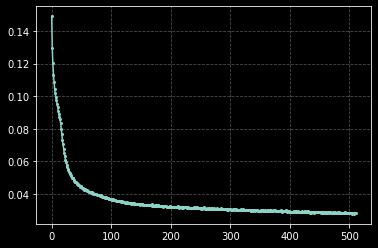

In [294]:
plt.plot(hist.history["loss"], '-o', ms=2)
#plt.yscale("log")
plt.grid(ls='--', alpha=0.3)

#### > test 3: n-hidden=(64, 4), losss='mean_absolute_error', optimizer = 'adam', (nro de capas)=n1,n2,n3=64,4,1

38430/38430 [==============================] - 6s 144us/step

Test accuracy: 0.039258997128549855
 --> plotting...


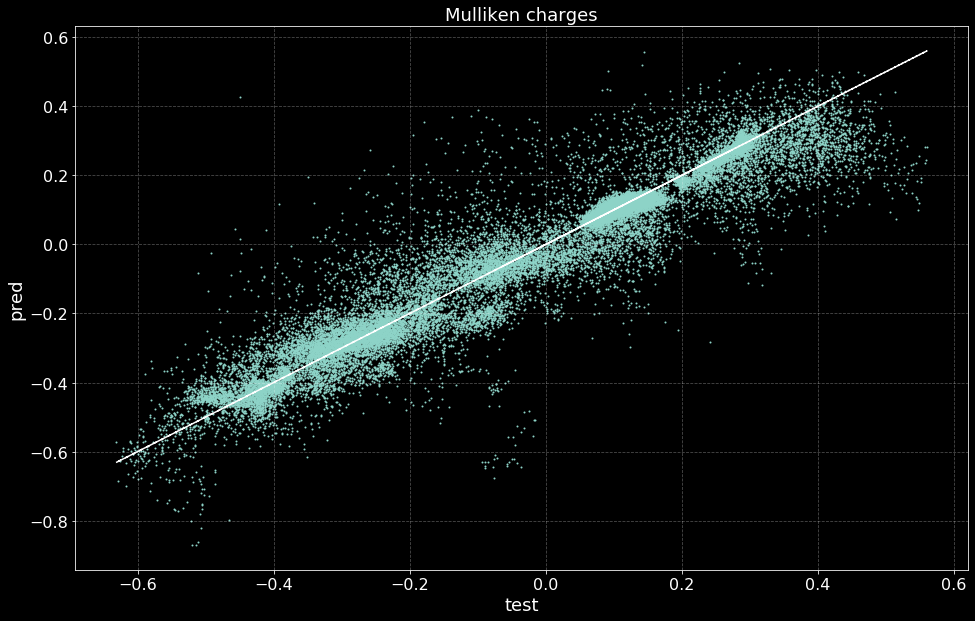

In [271]:
score = model.evaluate((X_test - scl_mean)/scl_norm, Y_test, verbose=1)
print('\nTest accuracy:', score)

y_pred = model.predict((X_test - scl_mean).values/scl_norm)
y_pred

print(" --> plotting...")
plt.figure(figsize=(16,10))
plt.scatter(Y_test, y_pred, s=1)
plt.plot(Y_test, Y_test, '--w')
plt.grid(ls='--', alpha=0.3)
plt.title("Mulliken charges", fontsize=18)
plt.xlabel("test", fontsize=18); plt.ylabel("pred", fontsize=18);
plt.tick_params(labelsize=16)
#plt.xlim(-1,1); plt.ylim(-1,1);

#### > test 2: n-hidden=(64, 4), loss='mean_squared_error', optimizer = 'adam', --> 'mse'

38430/38430 [==============================] - 6s 148us/step

Test accuracy: 0.00660479133631215
 --> plotting...


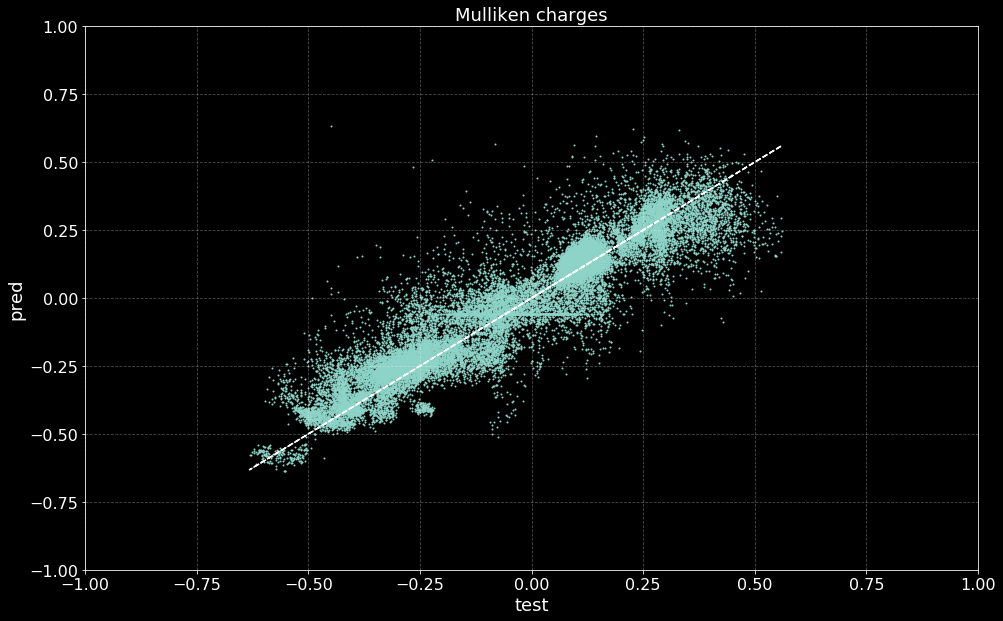

In [265]:
score = model.evaluate((X_test - scl_mean)/scl_norm, Y_test, verbose=1)
print('\nTest accuracy:', score)

y_pred = model.predict((X_test - scl_mean).values/scl_norm)
y_pred

print(" --> plotting...")
plt.figure(figsize=(16,10))
plt.scatter(Y_test, y_pred, s=1)
plt.plot(Y_test, Y_test, '--w')
plt.grid(ls='--', alpha=0.3)
plt.title("Mulliken charges", fontsize=18)
plt.xlabel("test", fontsize=18); plt.ylabel("pred", fontsize=18);
plt.tick_params(labelsize=16)
plt.xlim(-1,1); plt.ylim(-1,1);

#### > test 1: n-hidden=(10, 4), losss='mean_squared_error', optimizer = 'adam'

 --> plotting...


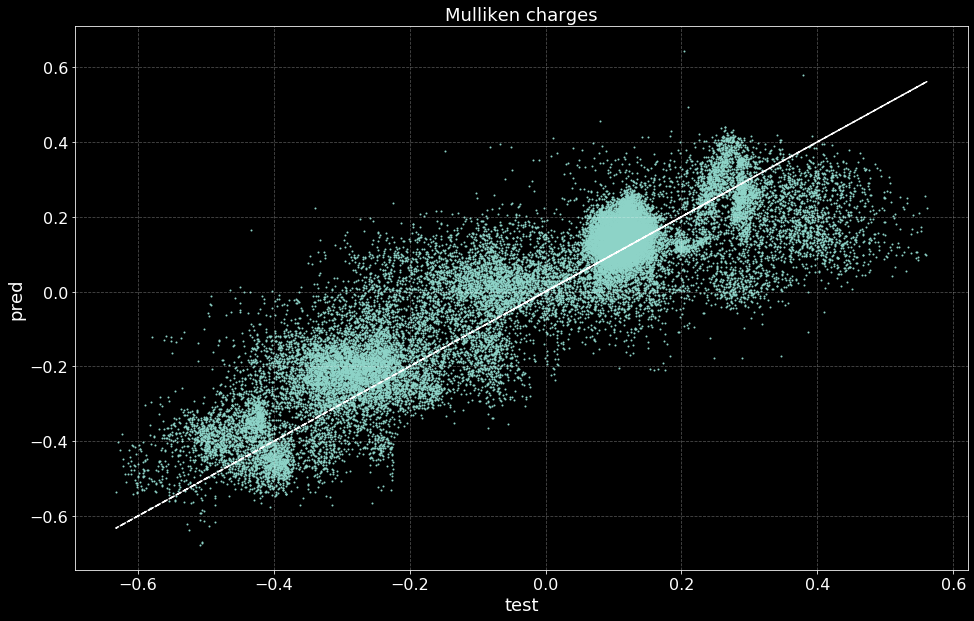

In [202]:
y_pred = model.predict(X_test.values)
y_pred

print(" --> plotting...")
plt.figure(figsize=(16,10))
plt.scatter(Y_test, y_pred, s=1)
plt.plot(Y_test, Y_test, '--w')
plt.grid(ls='--', alpha=0.3)
plt.title("Mulliken charges", fontsize=18)
plt.xlabel("test", fontsize=18); plt.ylabel("pred", fontsize=18);
plt.tick_params(labelsize=16)